# In this file we test all NFT functions from nft_analyse.py

## Import

In [9]:
from FNFTpy import nsev, nsev_poly
from FNFTpy import nsev_inverse, nsev_inverse_xi_wrapper
import numpy as np
import pandas as pd
import random
import timeit
from tqdm import tqdm
from scipy.fft import fft, ifft, fftfreq, fftshift, ifftshift

import matplotlib.pyplot as plt
import matplotlib

from importlib import reload

# from root_finding import jenkins_traub
# from nft_handling import test_signals
# from pjt import pjt

import signal_handling.signal_generation as sg
import signal_handling.ssfm as ssfm
import nft_handling.nft_analyse as nft
import nft_handling.test_signals as test_signals

reload(ssfm)
reload(sg)
reload(nft)


<module 'nft_handling.nft_analyse' from '/home/esf0/PycharmProjects/nft_processing/nft_handling/nft_analyse.py'>

## Create signal

2 [0.+1.4993749j 0.+0.4993749j]


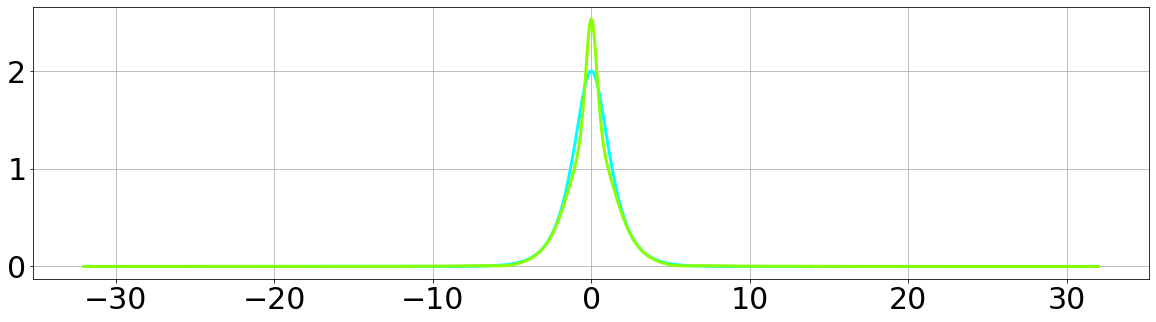

In [7]:
ampl = 2
chirp = 0.1

t_span = 64.0
n_t = 2 ** 10

dt = t_span / (n_t - 1)
t = np.array([i * dt - t_span / 2. for i in range(n_t)])

xi_span = np.pi / dt
n_xi = 2 ** 8
d_xi = xi_span / (n_xi - 1)
xi = np.array([i * d_xi - xi_span / 2. for i in range(n_xi)])

q, a_xi, b_xi, xi_discr, b_discr, r_discr, ad_discr = test_signals.get_sech(t, xi, a=ampl, c=chirp)
print(len(xi_discr), xi_discr)
z_prop = 4.3
q_prop = ssfm.fiber_propogate(q, t_span, z_prop, n_span=2 ** 9, gamma=1, beta2=-1)

matplotlib.rcParams.update({'font.size': 30})
# color = ['red', 'blue', 'green', 'xkcd:light purple', 'xkcd:cyan']
fig, axs = plt.subplots(1, 1, figsize=(20, 5))
axs.plot(t, np.absolute(q), 'xkcd:cyan', linewidth=3)
axs.plot(t, np.absolute(q_prop), 'xkcd:lime green', linewidth=3)
axs.grid(True)

# print(b_xi)

result_cont = get_continuous_spectrum(q, t, xi=None, type='fnft', xi_upsampling=1, fnft_type=0, nft_type='bo', res_poly=None, coefficient_type='left')

In [12]:
z_back = z_prop
xi_upsampling = 1
forward_continuous_type='fnft'
forward_discrete_type='fnft'
forward_discrete_coef_type='bi-direct'
inverse_type='both'
fnft_type=0
nft_type='bo'
use_contour = False
n_discrete_skip = 2

res_dbp = nft.make_dbp_nft_old(q_prop, t, z_back, xi_upsampling=xi_upsampling,
                           forward_continuous_type=forward_continuous_type,
                           forward_discrete_type=forward_discrete_type,
                           forward_discrete_coef_type=forward_discrete_coef_type,
                           inverse_type=inverse_type,
                           fnft_type=fnft_type, nft_type=nft_type,
                           use_contour=use_contour, n_discrete_skip=n_discrete_skip,
                           print_sys_message=True)

q_tib_total = res_dbp['q_total']
q_tib_left = res_dbp['q_tib_left']
q_tib_right = res_dbp['q_tib_right']
q_fnft = res_dbp['q_fnft']

xi_d_calculated = res_dbp['xi_d']
print(xi_d_calculated)
print(xi_discr)




# for fnft len(xi) == len(q)
res = nsev_inverse(xi, t, b_xi, xi_discr, b_discr / ad_discr, cst=1, dst=0, dis=fnft_type)
q_fnft_still = res['q']

print(np.shape(b_xi), np.shape(xi))

Number of discrete eigenvalues: 2
Time to calculate continuous part of z-chirp 32.94 ms
Time to calculate discrete part of z-chirp 0.31 ms
Time to calculate TIB 125.861 ms
Time to calculate continuous part of z-chirp 32.474999999999994 ms
Time to calculate discrete part of z-chirp 0.103 ms
Time to calculate TIB 122.953 ms
[ 3.20510855e-14+1.49937354j -5.42047895e-15+0.49852523j]
[0.+1.4993749j 0.+0.4993749j]
(256,) (256,)


/home/esf0/anaconda3/envs/nft_env/lib/python3.9/site-packages/FNFTpy/auxiliary.py:157: UserWarning: An error occured when calling FNFT: error code 2
  warn(wstring)
FNFT Error: Invalid argument M.
 in fnft_nsev_inverse(139)-0.4.1


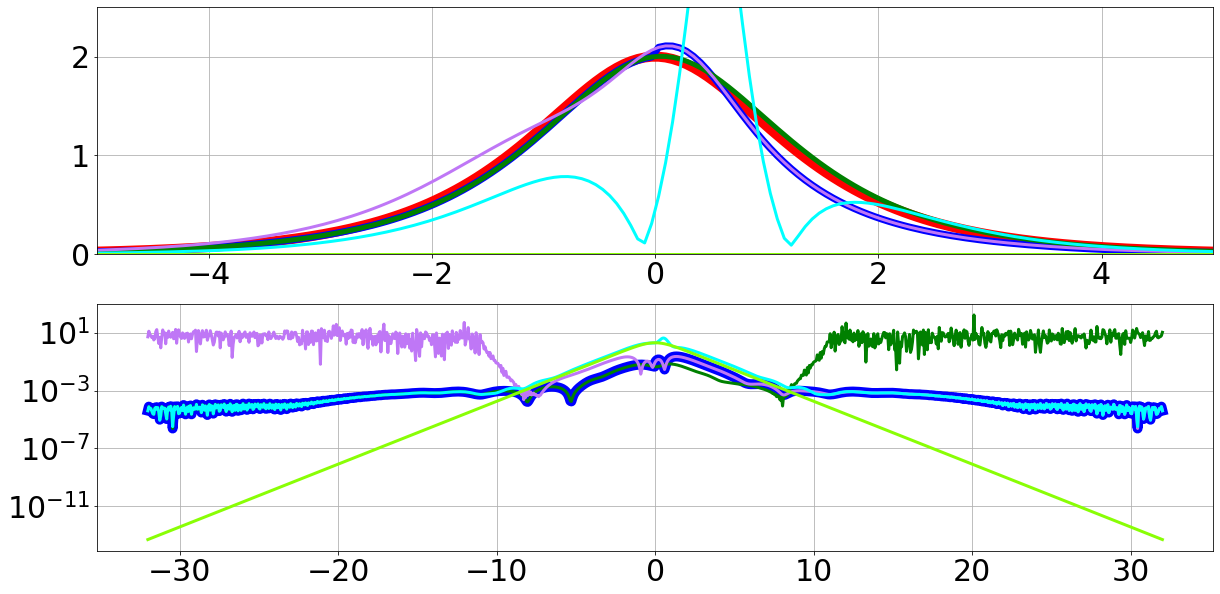

In [13]:
matplotlib.rcParams.update({'font.size': 30})
color = ['red', 'blue', 'green', 'xkcd:light purple', 'xkcd:cyan', 'xkcd:lime green']
fig, axs = plt.subplots(2, 1, figsize=(20, 10))
axs[0].plot(t, np.absolute(q), color[0], linewidth=10)
axs[0].plot(t, np.absolute(q_tib_total), color[1], linewidth=7)
axs[0].plot(t, np.absolute(q_tib_left), color[2], linewidth=5)
axs[0].plot(t, np.absolute(q_tib_right), color[3], linewidth=3)
axs[0].plot(t, np.absolute(q_fnft), color[4], linewidth=3)
axs[0].plot(t, np.absolute(q_fnft_still), color[5], linewidth=3)
axs[0].grid(True)
axs[0].set_xlim(-5, 5)
axs[0].set_ylim(0, ampl + 0.5)

axs[1].plot(t, np.absolute(q - q_tib_total), color[1], linewidth=10)
axs[1].plot(t, np.absolute(q - q_tib_left), color[2], linewidth=3)
axs[1].plot(t, np.absolute(q - q_tib_right), color[3], linewidth=3)
axs[1].plot(t, np.absolute(q - q_fnft), color[4], linewidth=3)
axs[1].plot(t, np.absolute(q - q_fnft_still), color[5], linewidth=3)
axs[1].grid(True)
axs[1].set_yscale('log')

#set y ticks
y_major = matplotlib.ticker.LogLocator(base = 10.0, numticks = 5)
axs[1].yaxis.set_major_locator(y_major)
y_minor = matplotlib.ticker.LogLocator(base = 10.0, subs = np.arange(1.0, 10.0) * 0.1, numticks = 10)
axs[1].yaxis.set_minor_locator(y_minor)
axs[1].yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

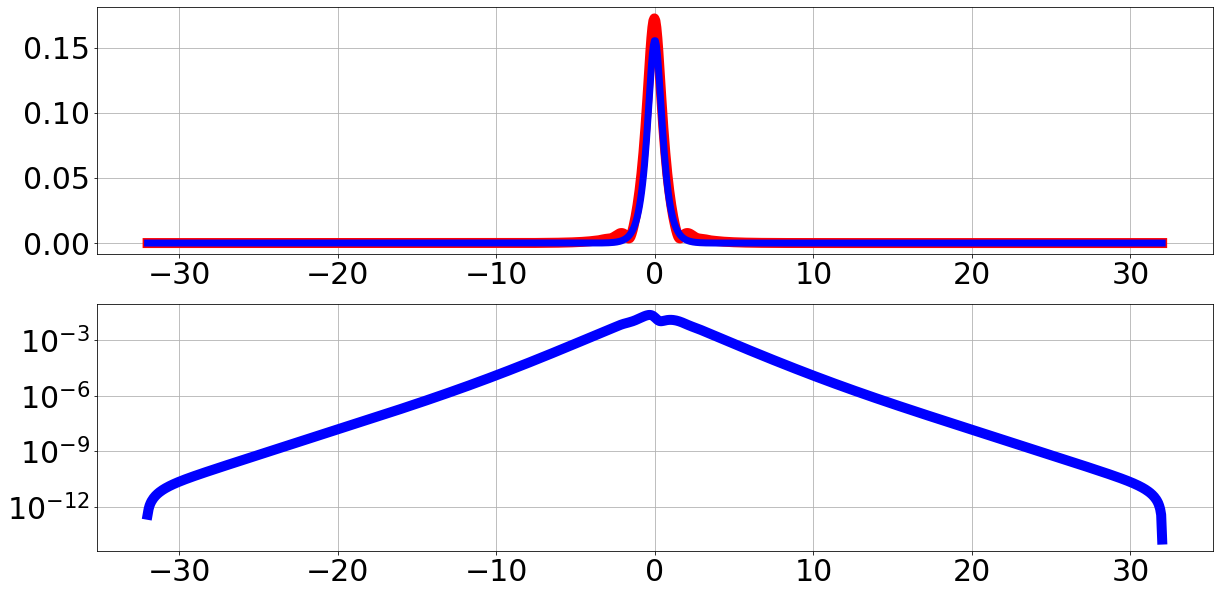

In [170]:
matplotlib.rcParams.update({'font.size': 30})
color = ['red', 'blue', 'green', 'xkcd:light purple', 'xkcd:cyan']
fig, axs = plt.subplots(2, 1, figsize=(20, 10))
axs[0].plot(t, np.absolute(res_dbp['b_prop']), color[0], linewidth=10)
axs[0].plot(t, np.absolute(b_xi), color[1], linewidth=7)
axs[0].grid(True)
# axs[0].set_xlim(-5, 5)
# axs[0].set_ylim(0, ampl + 0.5)

axs[1].plot(t, np.absolute(res_dbp['b_prop'] - b_xi), color[1], linewidth=10)
axs[1].grid(True)
axs[1].set_yscale('log')

#set y ticks
y_major = matplotlib.ticker.LogLocator(base = 10.0, numticks = 5)
axs[1].yaxis.set_major_locator(y_major)
y_minor = matplotlib.ticker.LogLocator(base = 10.0, subs = np.arange(1.0, 10.0) * 0.1, numticks = 10)
axs[1].yaxis.set_minor_locator(y_minor)
axs[1].yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

## Test bi-directional for arbitrary spectral parameter

In [56]:
reload(nft)
contour_ampl = 0.1
xi_span_test = 2
n_xi_test = 2 ** 7
xi_test = nft.get_raised_contour(contour_ampl, xi_span_test, n_xi_test)

a_test, b_test = nft.do_bi_direct_arbitrary_array(q, t, xi_test, 'tes4')
b_xi_test = test_signals.get_sech_b_coef(xi_test, ampl, chirp)



In [29]:
print(xi_discr)
print(nft.do_bi_direct_arbitrary(q, t, xi_discr[0], 'tes4'))

[0.+1.4993749j 0.+0.4993749j]
((5.5508636205285225e-08-4.334753515793568e-18j), (-0.9982872214516879+0.044181522832452066j))


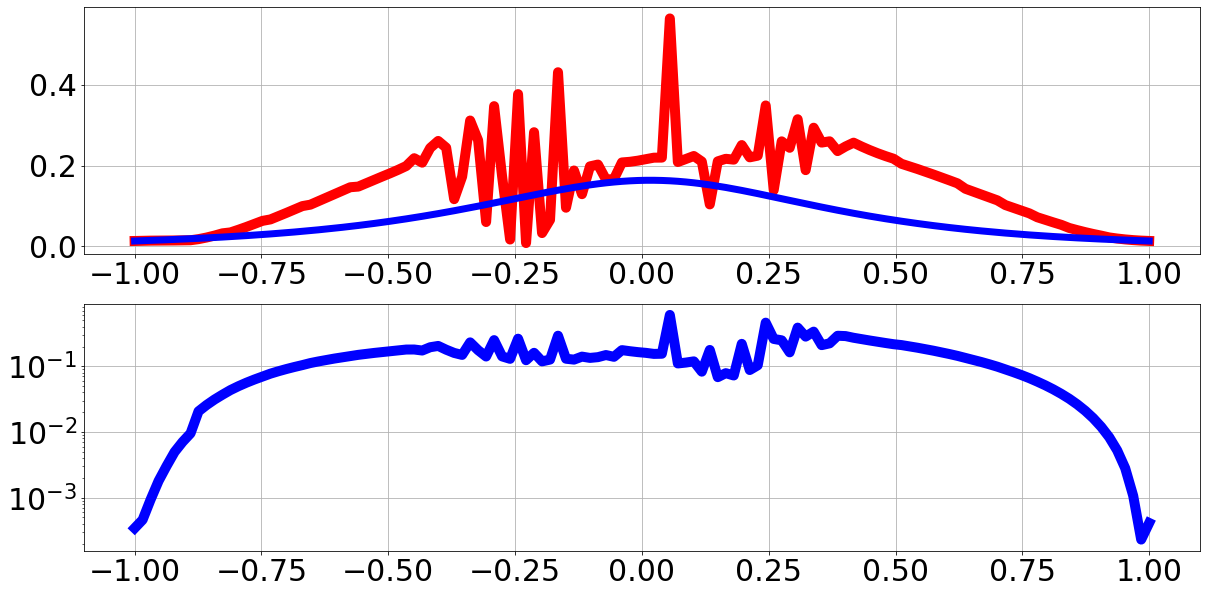

In [57]:
matplotlib.rcParams.update({'font.size': 30})
color = ['red', 'blue', 'green', 'xkcd:light purple', 'xkcd:cyan']
fig, axs = plt.subplots(2, 1, figsize=(20, 10))
axs[0].plot(np.real(xi_test), np.absolute(b_test), color[0], linewidth=10)
axs[0].plot(np.real(xi_test), np.absolute(b_xi_test), color[1], linewidth=7)
axs[0].grid(True)
# axs[0].set_xlim(-5, 5)
# axs[0].set_ylim(0, ampl + 0.5)

axs[1].plot(np.real(xi_test), np.absolute(b_test - b_xi_test), color[1], linewidth=10)
axs[1].grid(True)
axs[1].set_yscale('log')

#set y ticks
y_major = matplotlib.ticker.LogLocator(base = 10.0, numticks = 5)
axs[1].yaxis.set_major_locator(y_major)
y_minor = matplotlib.ticker.LogLocator(base = 10.0, subs = np.arange(1.0, 10.0) * 0.1, numticks = 10)
axs[1].yaxis.set_minor_locator(y_minor)
axs[1].yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())